# 1. Simple Exponential Smoothing
It is the method of time series forecasting used with univariate data with no trend and no seasonal pattern. It needs a single parameter called alpha (a), also known as the smoothing factor.

Exponential smoothing is a broadly accurate forecasting method for short-term forecasts. The technique assigns larger weights to more recent observations while assigning exponentially decreasing weights as the observations get increasingly distant. This method produces slightly unreliable long-term forecasts.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
import evds as e

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from arch.unitroot import ADF, KPSS
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pymannkendall import original_test

[*********************100%%**********************]  1 of 1 completed


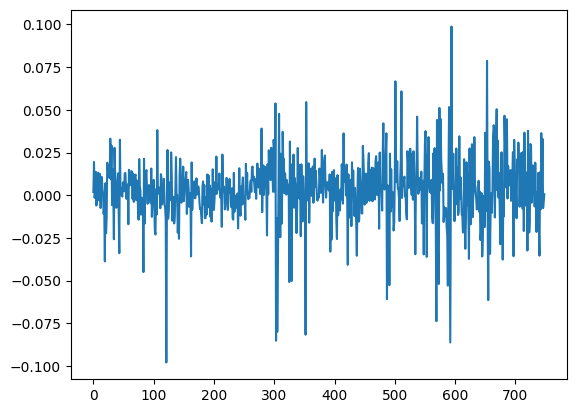

In [12]:
data = yf.download("XU100.IS", period="3Y", interval="1d")["Close"]
data = pd.DataFrame(data)
data["Return"] = data.pct_change()
data.dropna(inplace=True)
data.reset_index(inplace=True)

plt.plot(data["Return"])
plt.show()

In [13]:
# Let's check if there is a trend in Return values with ADF and KPSS test and see the series is stationary 
adf = ADF(data["Return"])
kpss = KPSS(data["Return"])

print(adf)
print(kpss)

   Augmented Dickey-Fuller Results   
Test Statistic                -12.104
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
    KPSS Stationarity Test Results   
Test Statistic                  0.211
P-value                         0.248
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


In [14]:
# Now apply the simple exponential smoothing method for short term forecast
ses = SimpleExpSmoothing(data["Return"])
model = ses.fit(smoothing_level=0.2, optimized=False)
forecast =  model.forecast(5)
print(forecast)

749    0.003236
750    0.003236
751    0.003236
752    0.003236
753    0.003236
dtype: float64


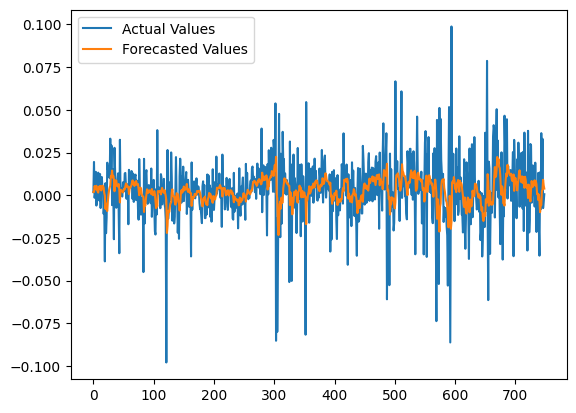

In [15]:
# Check out this method forecating for previos periods values and compare it with actual values.
previos_forecast = model.fittedvalues

plt.plot(data["Return"], label="Actual Values")
plt.plot(previos_forecast, label="Forecasted Values")
plt.legend()
plt.show()

In [16]:
# Let's get optimum alpha value
alphas = np.arange(0, 1, 0.1)
rmse_vals = []

for i in alphas:
    ses = SimpleExpSmoothing(data["Return"])
    model = ses.fit(smoothing_level=i, optimized=False)
    forecast =  model.fittedvalues
    rmse = np.sqrt(mean_squared_error(data["Return"], forecast))
    rmse_vals.append(rmse)

optimum_index = np.argmin(rmse_vals)
optium_value = rmse_vals[optimum_index]
print(optium_value)

0.01907622035401789


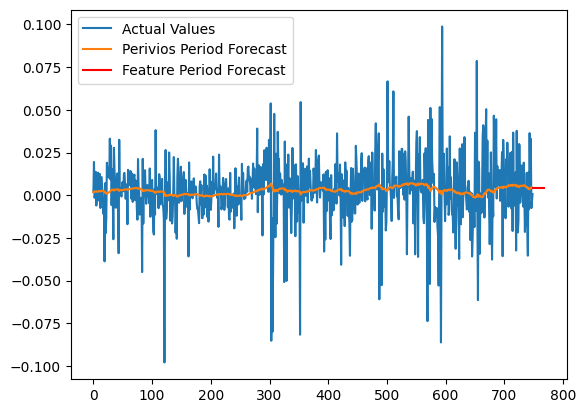

In [17]:
# Now do forecast with optimum value that we found above
ses = SimpleExpSmoothing(data["Return"])
model = ses.fit(smoothing_level=optium_value, optimized=False)
past_forecast =  model.fittedvalues
feature_forecast = model.forecast(20)

plt.plot(data["Return"], label="Actual Values")
plt.plot(past_forecast, label="Perivios Period Forecast")
plt.plot(feature_forecast, label="Feature Period Forecast", color="red")
plt.legend()
plt.show()

# 2. Double Exponential Smoothing
This method is known as Holt's trend model or second-order exponential smoothing. Double exponential smoothing is 
used in time-series forecasting when the data has a linear trend but no seasonal pattern. The basic idea here is to introduce 
a term that can consider the possibility of the series exhibiting some trend. 

In addition to the alpha parameter, Double exponential smoothing needs another smoothing factor called beta (b), 
which controls the decay of the influence of change in trend

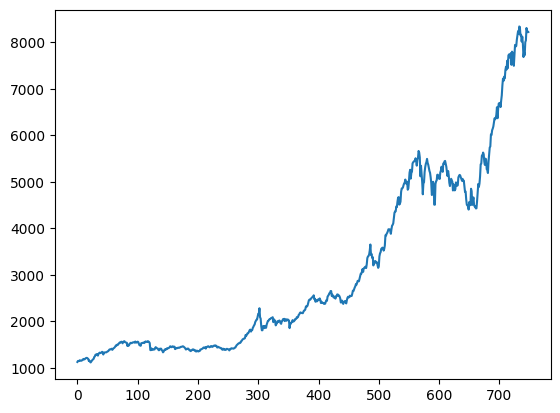

In [18]:
# Let's check out if there is a trend for closing price in the data
plt.plot(data["Close"])
plt.show()

In [19]:
# As we can see above graph there is a increasing trend in the series but let's verfy it with pymannkendall statistical test
mk = original_test(data["Close"])
print(mk)

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=34.09801624147887, Tau=0.8325539221635978, s=233220.0, var_s=46781014.0, slope=7.123106403331473, intercept=-457.5417948459708)


In [21]:
# Now we can implement the double exponential smoothing method
des = Holt(data["Close"])
model = des.fit(smoothing_level=0.9, smoothing_slope=0.6, optimized=False)
forecast = model.forecast(20)
print(forecast)

749    8215.888249
750    8212.425580
751    8208.962910
752    8205.500241
753    8202.037572
754    8198.574902
755    8195.112233
756    8191.649564
757    8188.186894
758    8184.724225
759    8181.261555
760    8177.798886
761    8174.336217
762    8170.873547
763    8167.410878
764    8163.948208
765    8160.485539
766    8157.022870
767    8153.560200
768    8150.097531
dtype: float64


/var/folders/hq/f4fnfxxj0psb8f_l4kc58_tr0000gn/T/ipykernel_6372/900835664.py:3: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = des.fit(smoothing_level=0.9, smoothing_slope=0.6, optimized=False)


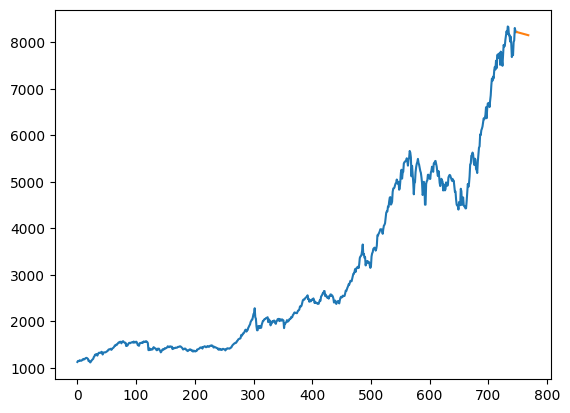

In [23]:
plt.plot(data["Close"])
plt.plot(forecast)
plt.show()

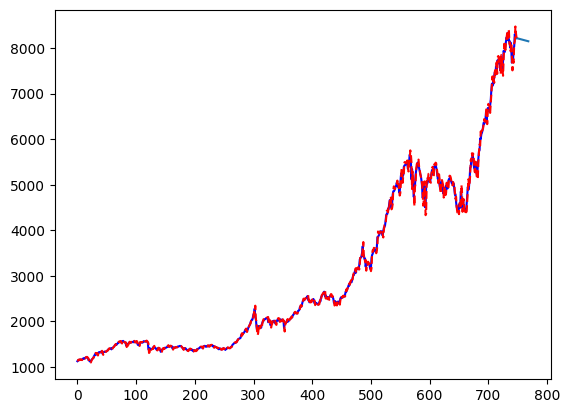

In [27]:
# Check out how the model make forecast for historical values
past = model.fittedvalues

plt.plot(data["Close"], color = "blue")
plt.plot(forecast)
plt.plot(past, color="red", linestyle="--")
plt.show()

In [33]:
# using optimized parameter
des = Holt(data["Close"])
model2 = des.fit(optimized=True, use_brute=True)
forecast2 = model2.forecast(20)
past2 = model2.fittedvalues

#write a funtion to calculate error
def errorCalculation(y, forecast):
    print("MSE Score: {}".format(mean_squared_error(y, forecast)))
    print("RMSE Score: {}".format(np.sqrt(mean_squared_error(y, forecast))))
    print("MAE Score: {}".format(mean_absolute_error(y, forecast)))

In [32]:
#Compare error results optimized and non optimized method
errorCalculation(data["Close"], past)
print("-"*30)
errorCalculation(data["Close"], past2)

MSE Score: 7953.4900442079015
RMSE Score: 89.18234154925459
MAE Score: 51.86091029209493
------------------------------
MSE Score: 5991.987010124925
RMSE Score: 77.40792601617049
MAE Score: 45.085093877800965


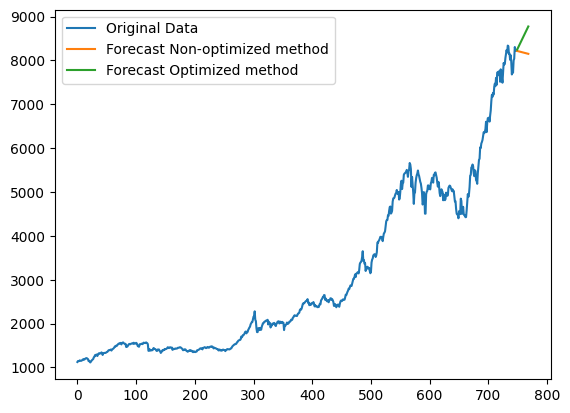

In [35]:
# Let's see comparision of original values with forecasted value
plt.plot(data["Close"], label="Original Data")
plt.plot(forecast, label="Forecast Non-optimized method")
plt.plot(forecast2, label="Forecast Optimized method")
plt.legend()
plt.show()

# 23. Triple Exponential Smoothing
Triple exponential smoothing is used to handle the time series data containing a seasonal component. This method is based on three smoothing equations: stationary component, trend, and seasonal. Both seasonal and trend can be additive or multiplicative.

In [2]:
with open("/Users/neseuygun/Desktop/evds_api_key.txt") as file:
    api = file.read()

evds = e.evdsAPI(api)
data = evds.get_data(["TP.GSYIH26.HY.ZH"], startdate="01-01-1998", enddate="01-01-2023")
data

,Tarih,TP_GSYIH26_HY_ZH
0,1998-Q1,1.581245e+08
1,1998-Q2,1.721125e+08
2,1998-Q3,1.953092e+08
3,1998-Q4,1.852111e+08
4,1999-Q1,1.486788e+08
...,...,...
96,2022-Q1,4.701431e+08
97,2022-Q2,5.071277e+08
98,2022-Q3,5.631055e+08
99,2022-Q4,5.816904e+08


In [3]:
data["Tarih"] = pd.date_range("01-01-1998", periods=len(data), freq="Q")
data.rename(columns={"Tarih":"Date", "TP_GSYIH26_HY_ZH":"GDP"}, inplace=True)
data.set_index("Date", inplace=True)
data

,GDP
Date,
1998-03-31,1.581245e+08
1998-06-30,1.721125e+08
1998-09-30,1.953092e+08
1998-12-31,1.852111e+08
1999-03-31,1.486788e+08
...,...
2022-03-31,4.701431e+08
2022-06-30,5.071277e+08
2022-09-30,5.631055e+08


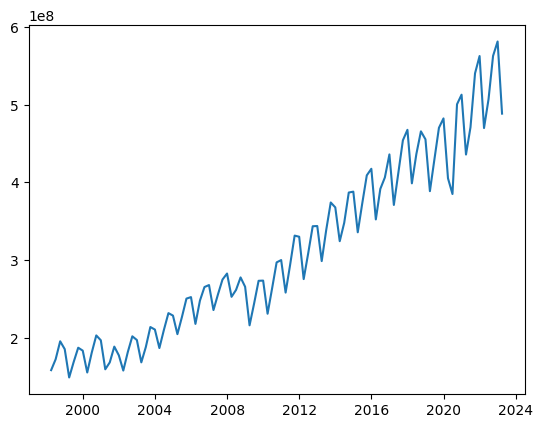

In [4]:
# Quick review with plot
plt.plot(data)
plt.show()

In [7]:
# Set the TES model
tes = ExponentialSmoothing(data["GDP"], trend="add", seasonal="add", seasonal_periods=4)
model = tes.fit(smoothing_level=0.5, smoothing_slope=0.5, smoothing_seasonal=0.5, optimized=False)
forecast = model.forecast(24)
print(forecast)

2023-06-30    5.156458e+08
2023-09-30    5.736204e+08
2023-12-31    5.939878e+08
2024-03-31    5.027707e+08
2024-06-30    5.285345e+08
2024-09-30    5.865091e+08
2024-12-31    6.068765e+08
2025-03-31    5.156594e+08
2025-06-30    5.414232e+08
2025-09-30    5.993978e+08
2025-12-31    6.197651e+08
2026-03-31    5.285480e+08
2026-06-30    5.543118e+08
2026-09-30    6.122864e+08
2026-12-31    6.326538e+08
2027-03-31    5.414367e+08
2027-06-30    5.672005e+08
2027-09-30    6.251751e+08
2027-12-31    6.455425e+08
2028-03-31    5.543254e+08
2028-06-30    5.800892e+08
2028-09-30    6.380638e+08
2028-12-31    6.584311e+08
2029-03-31    5.672140e+08
Freq: Q-DEC, dtype: float64


/Users/neseuygun/Desktop/Time_Series/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/hq/f4fnfxxj0psb8f_l4kc58_tr0000gn/T/ipykernel_5894/447249366.py:3: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = tes.fit(smoothing_level=0.5, smoothing_slope=0.5, smoothing_seasonal=0.5, optimized=False)


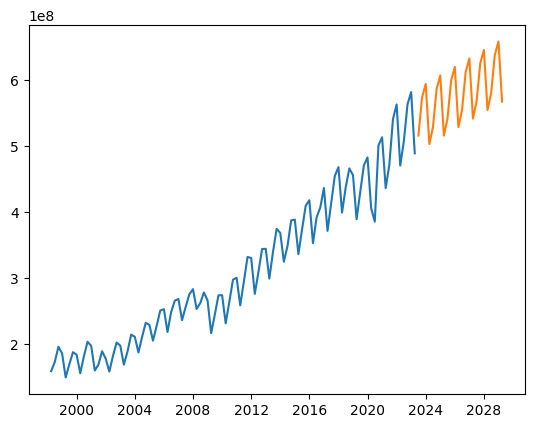

In [8]:
plt.plot(data)
plt.plot(forecast)
plt.show()

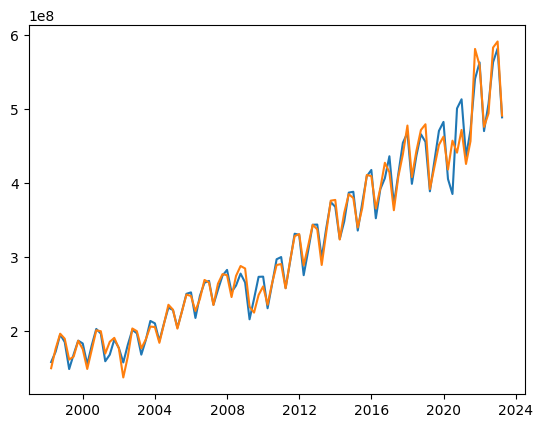

In [9]:
# Now let's check model forecast for historical values and compare with original values
past3 = model.fittedvalues

plt.plot(data)
plt.plot(past3)
plt.show()